# Evaluation of trained network for temporal super-resolution

In [1]:
#%matplotlib notebook
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython.display import display
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils.evaluate_utils import *
import pandas as pd
import matplotlib.cm as cm
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

In [2]:
df = pd.read_csv('../results/Overview_models.csv')
df1 = df[['Name', 'notes']]
display(df1)

,Name,notes
0,Temporal4DFlowNet_20230210-0333,NaN
1,Temporal4DFlowNet_20230215-1029,NaN
2,Temporal4DFlowNet_20230217-0602,NaN
3,Temporal4DFlowNet_20230220-0908,NaN
4,Temporal4DFlowNet_20230301-1127,First training on radial sampled data
5,Temporal4DFlowNet_20230301-1641,Basecheck with adapted network code and higher...
6,Temporal4DFlowNet_20230301-1654,First training with densenet blocks (Densenet)
7,Temporal4DFlowNet_20230301-1704,First training with cspnet blocks (CSPnet)
8,Temporal4DFlowNet_20230305-1001,Less depth: 4 -2
9,Temporal4DFlowNet_20230305-1002,Depth change (balance between high lowres bloc...


### Set model and dataset to evaluate


In [3]:
# Define directories and filenames

model_name = '20230405-1417'#'20230308-1226'#'20230404-1418'#'20230313-0948'#'20230301-1641'  #'20230308-1226'# #'#'20230308-1226' #'20230301-1641'  '20230301-1654', '20230301-1704'
set_name = 'Test'               
data_model= '4'
step = 2

use_dynamical_mask = True
offset = False

### Set evaluation files to compare relative error to


In [13]:
vel_colnames=['u', 'v', 'w']
vel_colnames_fluid = ['u_fluid', 'v_fluid', 'w_fluid']

def load_data(model_name, set_name, data_model, step,dynamic_mask_used, ending_file= ''):
    #directories
    gt_dir = '../data/CARDIAC'
    result_dir = f'../results/Temporal4DFlowNet_{model_name}'
    eval_dir = f'{result_dir}/plots'
    lr_dir = '../data/CARDIAC'

    inbetween_string = ''
    add_offset = ''
    if dynamic_mask_used:
        inbetween_string = '_dynamic'
    if offset:
        print('LR is now sampled with offset of 1')
        add_offset = '_offset1'
        offset_val = 1
    else:
        offset_val = 0

    #filenames
    gt_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}.h5'
    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'
    result_filename = f'{set_name}set_result_model{data_model}_2mm_step{step}_{model_name[-4::]}_temporal{ending_file}{add_offset}.h5' #_newpadding
    evaluation_filename = f'eval_rel_err_{data_model}_2mm_step{step}_{model_name[-4::]}_temporal.h5'

    print(gt_filename, lr_filename)

    if not os.path.isdir(eval_dir):
        os.makedirs(eval_dir)

    #Params for evalation
    save_relative_error_file= False

    # Setting up
    gt_filepath = '{}/{}'.format(gt_dir, gt_filename)
    res_filepath = '{}/{}'.format(result_dir, result_filename)
    lr_filepath = '{}/{}'.format(lr_dir, lr_filename)
    

    if save_relative_error_file:
        assert(not os.path.exists(f'{result_dir}/{evaluation_filename}')) #STOP if relative error file is already created

    
    gt = {}
    lr = {}
    pred = {}

    with h5py.File(res_filepath, mode = 'r' ) as h_pred:
        with h5py.File(gt_filepath, mode = 'r' ) as h_gt:
            with h5py.File(lr_filepath, mode = 'r' ) as h_lr:
                
                gt["mask"] = np.asarray(h_gt["mask"]).squeeze()
                gt["mask"][np.where(gt["mask"] !=0)] = 1
                if len(gt['mask'].shape) == 4 : # check for dynamical mask, otherwise create one
                    temporal_mask = gt['mask'].copy()
                else:
                    print('Create static temporal mask for model')
                    temporal_mask = create_temporal_mask(gt["mask"], h_gt['u'].shape[0])
                gt['mask'] = temporal_mask.copy()
                # adapt dimension
                for vel in vel_colnames:
                    
                    gt[vel] = np.asarray(h_gt[vel])
                    pred[vel] = np.asarray(h_pred[f'{vel}_combined'])   
                    lr[vel] = np.asarray(h_lr[vel])[offset_val::2, :, :, :]       

                    # add information considering only the fluid regions  
                    pred[f'{vel}_fluid'] =np.multiply(pred[vel], temporal_mask)
                    lr[f'{vel}_fluid'] =  np.multiply(lr[vel], temporal_mask[offset_val::2, :, :, :])
                    gt[f'{vel}_fluid'] =  np.multiply(gt[vel], temporal_mask)

                    
                #include speed calculations
                gt['speed']   = np.sqrt(gt["u"]**2 + gt["v"]**2 + gt["w"]**2)
                lr['speed']   = np.sqrt(lr["u"]**2 + lr["v"]**2 + lr["w"]**2)
                pred['speed'] = np.sqrt(pred["u"]**2 + pred["v"]**2 + pred["w"]**2)

                gt['speed_fluid']   = np.multiply(pred['speed'], temporal_mask)
                lr['speed_fluid']   = np.multiply(lr['speed'], temporal_mask[offset_val::2, :, :, :])
                pred['speed_fluid'] = np.multiply(gt['speed'], temporal_mask)


    return lr, gt, pred, temporal_mask, eval_dir

def load_interpolation(data_model, step, lr, gt, use_dynamical_mask):
    
    interpolate_NN = {}
    interpolate_linear = {}
    interpolate_cubic = {}


    inbetween_string = ''
    if use_dynamical_mask:
        inbetween_string = '_dynamic'

    lr_filename = f'M{data_model}_2mm_step{step}_static{inbetween_string}_noise.h5'


    interpolation_file= f'../results/interpolation/{lr_filename[:-3]}_interpolation'
    if not os.path.isfile(interpolation_file):
        print("Interpolation file does not exist - calculate interpolation and save files")
        print("Save interpolation files to: ", interpolation_file)
        
        #this can take a while
        for vel in vel_colnames:
            print("Interpolate low resolution images - ", vel)
            print(gt['mask'].shape)
            interpolate_linear[vel] = temporal_linear_interpolation(lr[vel], gt[vel].shape)
            interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])

            interpolate_cubic[vel] = temporal_cubic_interpolation(lr[vel], gt[vel].shape)
            interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])

            interpolate_NN[vel] = temporal_NN_interpolation(lr[vel], gt[vel].shape)
            interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

            prediction_utils.save_to_h5(interpolation_file, f'linear_{vel}' , interpolate_linear[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'cubic_{vel}' , interpolate_cubic[vel], compression='gzip')
            prediction_utils.save_to_h5(interpolation_file, f'NN_{vel}' , interpolate_NN[vel], compression='gzip')
    else:
        print("Load existing interpolation file")
        with h5py.File(interpolation_file, mode = 'r' ) as h_interpolate:
            for vel in vel_colnames:
                interpolate_linear[vel] = np.array(h_interpolate[f'linear_{vel}'])
                interpolate_cubic[vel] =  np.array(h_interpolate[f'cubic_{vel}'])
                interpolate_NN[vel] =     np.array(h_interpolate[f'NN_{vel}'])


                interpolate_linear[f'{vel}_fluid'] = np.multiply(interpolate_linear[vel], gt['mask'])
                interpolate_cubic[f'{vel}_fluid'] = np.multiply(interpolate_cubic[vel], gt['mask'])
                interpolate_NN[f'{vel}_fluid'] = np.multiply(interpolate_NN[vel], gt['mask'])

    return interpolate_linear, interpolate_cubic, interpolate_NN

lr, gt, pred, temporal_mask, eval_dir = load_data(model_name, set_name, data_model, step, use_dynamical_mask)
interpolate_linear, interpolate_cubic, interpolate_NN = load_interpolation(data_model, step,lr, gt, use_dynamical_mask)


       


M4_2mm_step2_static_dynamic.h5 M4_2mm_step2_static_dynamic_noise.h5
Load existing interpolation file
(1, 49, 62, 58, 84)


ValueError: zero-dimensional arrays cannot be concatenated

In [18]:
if use_dynamical_mask:
    inbetween_string = '_dynamic'

interpolate_sinc = {}
sinc_interpolate_file =  f'../data/CARDIAC/M{data_model}_2mm_step{step}_static{inbetween_string}_noise_sinc.h5'
with h5py.File(sinc_interpolate_file, mode = 'r' ) as h_sinc_interpolate:
    
    _, x, y, z = np.array(h_sinc_interpolate['u']).squeeze().shape
    print(x, y, z)
    for vel in vel_colnames:
        interpolate_sinc[vel] = np.array(h_sinc_interpolate[vel]).squeeze()
        interpolate_sinc[vel] = np.concatenate([interpolate_sinc[vel], np.zeros((1, x, y, z))],axis=0 )
        print('Interpolation shapes: ', interpolate_sinc[vel].shape)
        interpolate_sinc[f'{vel}_fluid'] = np.multiply(interpolate_sinc[vel], gt['mask'])

62 58 84
Interpolation shapes:  (50, 62, 58, 84)
Interpolation shapes:  (50, 62, 58, 84)
Interpolation shapes:  (50, 62, 58, 84)


### Calculate relative error and mean speed

In [19]:
rel_error =calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
error_pointwise, error_absolut = calculate_pointwise_error(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_lin_interpolation =   calculate_relative_error_normalized(interpolate_linear["u"], interpolate_linear["v"], interpolate_linear["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
rel_error_cubic_interpolation = calculate_relative_error_normalized(interpolate_cubic["u"], interpolate_cubic["v"], interpolate_cubic["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])

for vel in vel_colnames:
    error_absolut[f'{vel}_fluid'] = np.multiply(error_absolut[vel], gt["mask"])

# mean speed of gt and prediction
gt['mean_speed'] = calculate_mean_speed(gt["u_fluid"], gt["v_fluid"] , gt["w_fluid"], gt["mask"])
pred['mean_speed'] = calculate_mean_speed(pred["u_fluid"], pred["v_fluid"] , pred["w_fluid"], gt["mask"])
interpolate_linear['mean_speed'] = calculate_mean_speed(interpolate_linear["u_fluid"], interpolate_linear["v_fluid"] ,interpolate_linear["w_fluid"], gt["mask"])
interpolate_cubic['mean_speed'] = calculate_mean_speed(interpolate_cubic["u_fluid"], interpolate_cubic["v_fluid"] , interpolate_cubic["w_fluid"], gt["mask"])
interpolate_sinc['mean_speed'] = calculate_mean_speed(interpolate_sinc["u_fluid"], interpolate_sinc["v_fluid"] , interpolate_sinc["w_fluid"], gt["mask"])

max/min before tanh 44484.87 0.0
max/min after tanh 1.0 0.0
max/min before tanh 316548.22 0.0
max/min after tanh 1.0 0.0
max/min before tanh 1304849.0 0.0
max/min after tanh 1.0 0.0


In [20]:
vel_colnames = ['u', 'v', 'w']
min_v = {}
max_v = {}
for vel in vel_colnames:
    min_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
    max_v[vel] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

min_v['speed'] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.01)
max_v['speed'] = np.quantile(gt[vel][np.where(temporal_mask !=0)].flatten(), 0.99)

#get boundary points
bounds, core_mask = get_boundaries(temporal_mask)


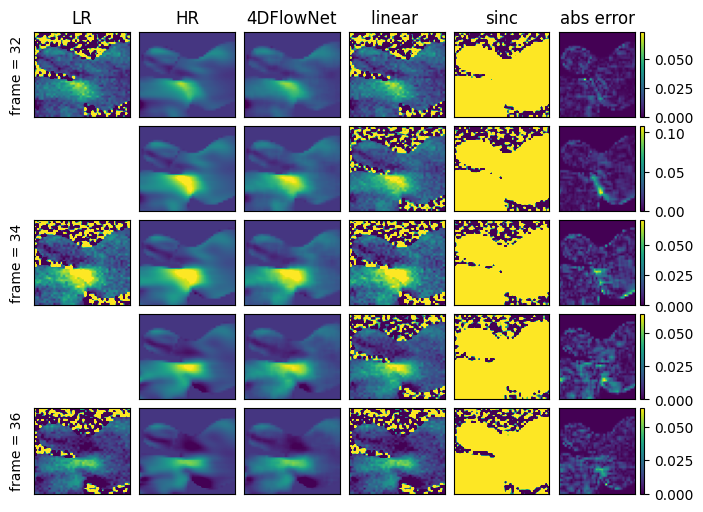

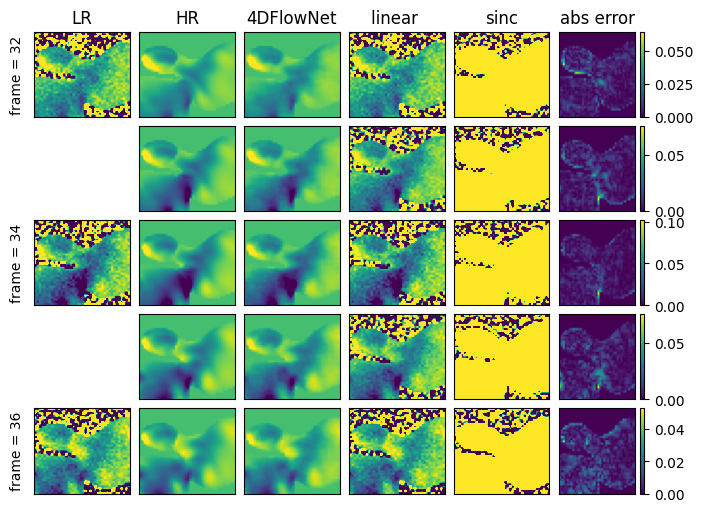

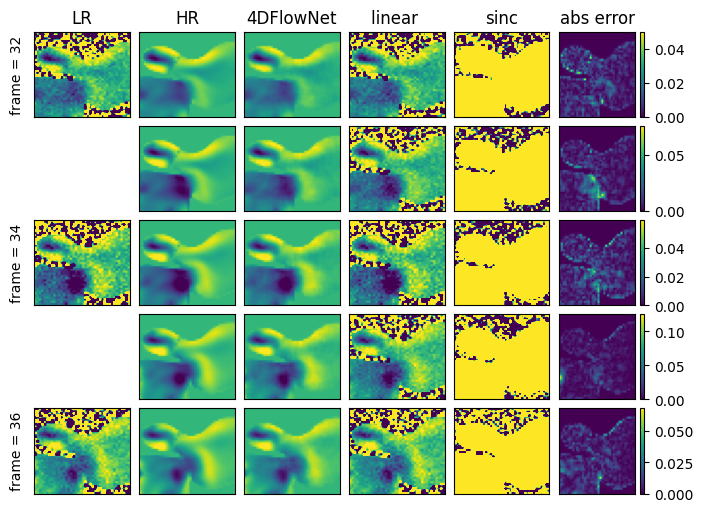

In [22]:

def show_timeframes_jupyter(gt_cube,lr_cube,  pred_cube,mask_cube, rel_error_cube, comparison_lst, comparison_name, timepoints, axis, idx,min_v, max_v,save_as = "Frame_comparison.png"):
    fig = plt.figure(figsize=(8,6))
    T = len(timepoints)
    N = 4 + len(comparison_lst)
    i = 1
    idxs = get_indices(timepoints, axis, idx)
    gt_cube = gt_cube[idxs]
    mask_cube = mask_cube[idxs]
    pred_cube = pred_cube[idxs]
    #lr = lr[idxs]

    min_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.01)
    max_v = np.quantile(gt_cube[np.where(mask_cube !=0)].flatten(), 0.99)
    for j,t in enumerate(timepoints):
        
        gt_slice = gt_cube[j]#get_slice(gt, t,  axis=axis, slice_idx=idx )
        pred_slice = pred_cube[j]#get_slice(pred, t, axis=axis, slice_idx=idx )

        lr_slice = np.zeros_like(gt_slice)
        if t%2 == 0: lr_slice = get_slice(lr_cube, t//2, axis=axis, slice_idx=idx )

        plt.subplot(T, N, i)

        if t%2 == 0:
            plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i == 1: plt.title("LR")
            plt.xticks([])
            plt.yticks([])
            plt.ylabel('frame = '+ str(t))
            
        else:
            #plt.imshow(lr_slice, vmin = min_v, vmax = max_v, cmap='jet', aspect='auto')
            plt.ylabel('frame = '+ str(t))
            plt.axis('off')
        

        i +=1
        plt.subplot(T, N, i)
        plt.imshow(gt_slice, vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
        if i == 2: plt.title("HR")
        plt.xticks([])
        plt.yticks([])

        i +=1
        plt.subplot(T, N, i)
        plt.imshow(pred_slice, vmin = min_v, vmax = max_v, cmap='viridis',aspect='auto')
        if i == 3: plt.title("4DFlowNet")
        plt.xticks([])
        plt.yticks([])


        for comp, name in zip(comparison_lst, comparison_name):
            i +=1
            plt.subplot(T, N, i)
            plt.imshow(get_slice(comp,t, axis=axis, slice_idx=idx), vmin = min_v, vmax = max_v, cmap='viridis', aspect='auto')
            if i-1 == (i-1)%N: plt.title(name)
            plt.xticks([])
            plt.yticks([])

        # plt.colorbar(get_slice(comp,t, axis=axis, slice_idx=idx))

        # fig.subplots_adjust(right=0.8)
        # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        # fig.colorbar(cax=cbar_ax)   

        i +=1
        plt.subplot(T, N, i)
        plt.imshow(get_slice(rel_error_cube, t, axis, idx),cmap='viridis',aspect='auto')
        if i-1 == (i-1)%N: plt.title("abs error")
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()

        
        i +=1

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    plt.savefig(save_as,bbox_inches='tight' )
    # plt.tight_layout()

a = 0
idx_cube = np.index_exp[:, :, 0:40, 20:60]


show_timeframes_jupyter(gt['u'][idx_cube],lr['u'][idx_cube],  pred['u'][idx_cube],temporal_mask[idx_cube], error_absolut['u'][idx_cube], [interpolate_linear['u'][idx_cube],interpolate_sinc['u'][idx_cube]], ['linear ','sinc'], [32, 33, 34, 35, 36], axis=a, idx=30,min_v = min_v['u'], max_v = max_v['u'],save_as = f"{eval_dir}/Frame_comparison_u.png")
show_timeframes_jupyter(gt['v'][idx_cube],lr['v'][idx_cube],  pred['v'][idx_cube],temporal_mask[idx_cube], error_absolut['v'][idx_cube], [interpolate_linear['v'][idx_cube],interpolate_sinc['v'][idx_cube]], ['linear ','sinc'], [32, 33, 34, 35, 36], axis=a, idx=30,min_v = min_v['v'], max_v = max_v['v'],save_as = f"{eval_dir}/Frame_comparison_v.png")
show_timeframes_jupyter(gt['w'][idx_cube],lr['w'][idx_cube],  pred['w'][idx_cube],temporal_mask[idx_cube], error_absolut['w'][idx_cube], [interpolate_linear['w'][idx_cube],interpolate_sinc['w'][idx_cube]], ['linear ','sinc'], [32, 33, 34, 35, 36], axis=a, idx=30,min_v = min_v['w'], max_v = max_v['w'],save_as = f"{eval_dir}/Frame_comparison_w.png")



#### Compare different axis predicrrion with averaged prediction


In [ ]:
# pred_axis0 = {}
# pred_axis1 = {}
# pred_axis2 = {}
# vel_colnames=['u', 'v', 'w']
# #Compare the combined and not combined evaulations
# with h5py.File(res_filepath, mode = 'r' ) as h_pred:
#     for vel in vel_colnames:
#         pred_axis0[vel] = np.asarray(h_pred[f'{vel}_axis0'])   
#         pred_axis1[vel] = np.asarray(h_pred[f'{vel}_axis1'])  
#         pred_axis2[vel] = np.asarray(h_pred[f'{vel}_axis2'])  

#         pred_axis0[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis0[vel])
#         pred_axis1[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis1[vel])
#         pred_axis2[f'{vel}_fluid'] = np.multiply(gt["mask"], pred_axis2[vel])

# rel_error_axis0 = calculate_relative_error_normalized(pred_axis0["u"], pred_axis0["v"], pred_axis0["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# rel_error_axis1 = calculate_relative_error_normalized(pred_axis1["u"], pred_axis1["v"], pred_axis1["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# rel_error_axis2 = calculate_relative_error_normalized(pred_axis2["u"], pred_axis2["v"], pred_axis2["w"], gt["u"], gt["v"] , gt["w"], gt["mask"])
# mean_speed_axis0 = calculate_mean_speed(pred_axis0["u_fluid"], pred_axis0["v_fluid"] , pred_axis0["w_fluid"], gt["mask"])
# mean_speed_axis1 = calculate_mean_speed(pred_axis1["u_fluid"], pred_axis1["v_fluid"] , pred_axis1["w_fluid"], gt["mask"])
# mean_speed_axis2 = calculate_mean_speed(pred_axis2["u_fluid"], pred_axis2["v_fluid"] , pred_axis2["w_fluid"], gt["mask"])



# plt.subplot(2, 1, 1)
# #plot_relative_error([gt_filepath],[res_filepath], [set_name])

# #plt.legend(lst_names)
# plt.title("Relative error")
# plt.plot(rel_error, label = 'averaged prediction')
# # plt.plot(rel_error_axis0, label = "axis 0")
# # plt.plot(rel_error_axis1, label = "axis 1")
# # plt.plot(rel_error_axis2, label = "axis 2")
# plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
# plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
# plt.plot(50*np.ones(len(rel_error)), 'k:')
# plt.xlabel("Frame")
# plt.ylabel("Relative error (%)")
# plt.ylim((0, 100))
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(gt['mean_speed'], label ='Ground truth',color = 'black')
# plt.plot(pred['mean_speed'],'b', label= set_name, color = 'steelblue')
# # plt.plot(mean_speed_axis0, label = "axis 0")
# # plt.plot(mean_speed_axis1, label = "axis 1")
# # plt.plot(mean_speed_axis2, label = "axis 2")
# plt.plot(interpolate_linear['mean_speed'][:-1], label = 'linear interpolation', color = 'yellowgreen')
# # plt.plot(mean_speed_cubic_interpolation[:-1], label = 'cubic interpoaltion', color = 'forestgreen')
# plt.xlabel("Frame")
# plt.ylabel("Mean speed (cm/s)")
# plt.legend()

# plt.savefig(f'{eval_dir}/Erl_error_{set_name}.svg')
# plt.show()



### Show results including non-fluid region
 

In [ ]:


@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames)
def f(frame=5, x = 10, vel = "u"):
    plt.figure(figsize=(20,10))
    plt.subplot(1, 5, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, :, :]), vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("LR")
    plt.axis('off')
    
    #plt.imshow(lr[vel][frame//t, x, :, :])
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(gt[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("SR")
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(interpolate_linear[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("Linear Interpolation")
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(interpolate_cubic[vel][frame, x, :, :], vmin = min_v[vel], vmax = max_v[vel])#, cmap='jet')
    plt.title("Cubic Interpolation")
    plt.axis('off')

    plt.tight_layout()
    plt.show()



### Show results with only fluid region

In [ ]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1), vel=vel_colnames_fluid, patch_size=(10, 30))
def f(frame=5, x = 10, vel = "u", patch_size=20):
    plt.figure(figsize=(20,10))
    N = 7
    mid_y = gt["u"].shape[2]//2
    mid_z = gt["u"].shape[3]//2
    idxs = np.index_exp[frame, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]

    plt.subplot(1, N, 1)
    if frame%2 == 0:
        plt.imshow(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    else:
        plt.imshow(np.zeros_like(lr[vel][frame//2, x, mid_y-patch_size:mid_y+patch_size, mid_z-patch_size:mid_z+patch_size]), vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("LR")
    plt.axis('off')
    
    plt.axis('off')

    plt.subplot(1, N, 2)
    plt.imshow(gt[vel][idxs], vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("GT")
    plt.axis('off')

    plt.subplot(1, N, 3)
    plt.imshow(pred[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("SR")
    plt.axis('off')

    plt.subplot(1, N, 4)
    plt.imshow(interpolate_linear[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Linear")
    plt.axis('off')

    plt.subplot(1, N, 5)
    plt.imshow(interpolate_cubic[vel][idxs],  vmin = min_v[vel[0]], vmax = max_v[vel[0]], cmap='viridis')
    plt.title("Cubic")
    plt.axis('off')

    plt.subplot(1, N, 6)
    plt.imshow(error_pointwise[idxs], cmap='viridis')
    plt.title("Relative error")
    plt.axis('off')

    plt.subplot(1, N, 7)
    plt.imshow(error_absolut[vel][idxs], cmap='viridis')
    plt.title("Absolute error")
    plt.axis('off')

    plt.tight_layout()
    #plt.colorbar()
    plt.show()

In [ ]:
## This is to plot the values in one line



t_idx = 34
z_idx = 22
gt_line = gt['u'][t_idx, z_idx, :, :]
lr_line = lr['u'][t_idx//2, z_idx, :, :]
pred_line = pred['u'][t_idx, z_idx, :, :]

x0, y0 = 30, 15
x1, y1 = 40, 35
num = int(np.hypot(x1-x0, y1-y0))
x, y = np.linspace(x0, x1, num), np.linspace(y0, y1, num)
gt_line_vals = gt_line[x.astype(int), y.astype(int)]#scipy.ndimage.map_coordinates(z, np.vstack((x,y)))
lr_line_vals = lr_line[x.astype(int), y.astype(int)]
pred_line_vals = pred_line[x.astype(int), y.astype(int)]


fig, axes = plt.subplots(nrows=2)
plt.subplot(2, 1, 1)
plt.imshow(gt_line)
plt.plot([x0, x1], [y0, y1], 'ro-')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.plot(gt_line_vals, label = 'gt')
plt.plot(lr_line_vals, label = 'lr')
plt.plot(pred_line_vals, label = 'pred')
plt.legend()
plt.ylabel('V_x (m/s)')
plt.xlabel('voxel number on line')

plt.show()

In [ ]:
## Here we want to create a plane trough the body
import matplotlib.cm as cm
from matplotlib.colors import Normalize
frame = 35
#plane parameters
point  = np.array([22, 25, 35])
x_line = 22
normal = np.array([-0.4, -0.5, 1]).astype(float) #[0, -0.5, 1]
normal /= np.linalg.norm(normal) #normalize normal
print('Normal vector norm:', np.linalg.norm(normal))

def plot_mean_speed_plane(idx_intersection_plane_fluid, data, mask, frames, label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)

    #Velocity through plane
    V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    mean_speed= np.mean(V_plane, axis = 1)*100
    if N_frames != frames:
        plt.plot(range(frames)[::2], mean_speed,'-o', color = 'yellowgreen', label = label)
    else:
        plt.plot(mean_speed,'-x', label = label, color = color)
    plt.xlabel('frame')
    plt.ylabel('Mean velocity (cm/s)')
    plt.title('Velocity through plane')
    #TODO check that this woukd be teh same for normal vect (0, 0, 1)(1, 0, 0) etc

def plot_line_speed(x_line,frame, data, normal, points_in_plane, label = '', color = 'black'):
    plane_slice = points_in_plane[x_line, :, :]

    idx_line_p = np.where(plane_slice == 1)
    # Get points
    line_points_idx = np.index_exp[frame, x_line, idx_line_p[0], idx_line_p[1]]

    V_line = data[line_points_idx]*100#np.sqrt(data['u'][line_points_idx]**2+ data['v'][line_points_idx]**2+ data['w'][line_points_idx]**2) *100#(data['u'][line_points_idx]*normal[0]+ data['v'][line_points_idx]*normal[1]+ data['w'][line_points_idx]*normal[2]) *100
    #project
    plt.plot(V_line, label = label, color = color)
    plt.xlabel('voxel number')
    plt.ylabel('V (cm/s)')
    plt.title(f'Speed on line in frame {frame}')



#get points for plotting model
x_bounds, y_bounds, z_bounds = np.where(bounds[frame, :, :,:]==1)

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

# calculate corresponding z
#TODO check if this is correct
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


#points in plane: 3D data, 1 where plane is, 0 where no plane
points_in_plane = np.zeros_like(gt['mask'][frame])
points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1
# points_in_plane[x_line, np.where(points_in_plane[x_line, :, :]==1)[0], np.where(points_in_plane[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

#3D model: ist just 1 in region, where plane AND fluid region is
points_plane_core = points_in_plane.copy()
points_plane_core[np.where(gt['mask'][frame]==0)] = 0
points_plane_core[x_line, np.where(points_plane_core[x_line, :, :]==1)[0], np.where(points_plane_core[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

#get indices
idx_intersec_plane_fluid = np.where(points_plane_core>0)
idx_plane =  np.where(points_in_plane>0)


vx_in_plane = gt['u'][frame][idx_plane].reshape(xx.shape[1], -1) 
vy_in_plane = gt['v'][frame][idx_plane].reshape(xx.shape[1], -1)
vz_in_plane = gt['w'][frame][idx_plane].reshape(xx.shape[1], -1)

#Velocity through plane
V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]

##Plotting
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1, 3, 1, projection='3d')
#plot 1
xp, yp, zp = idx_intersec_plane_fluid
ax.plot_surface(xx, yy, zz, alpha = 0.33, color = 'red') # plot plane
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
# ax.scatter3D(point[0], point[1], point[2],'x', color = 'red') #show point in plane
ax.scatter3D(xp, yp, zp) # plot point which intersect core region and plane
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

#plot 2
ax = fig.add_subplot(1, 3, 2, projection='3d')
plt.xlabel('x')
plt.ylabel('y')
ax.scatter(xx, yy, zz)
#plot 3
ax = fig.add_subplot(1, 3, 3, projection='3d')
xm, ym, zm, = np.where(points_plane_core ==1)#point_in_plane.nonzero()
xl, yl, zl = np.where(points_plane_core ==2) 
ax.scatter3D(xx, yy, zz, alpha = 0.05) 
#ax.scatter3D(xm, ym, zm, alpha=0.05)
ax.scatter3D(xp, yp, zp, s= 3, alpha = 0.3, color = 'red')
# ax.scatter3D(point[0], point[1], point[2],'x', color = 'red')
ax.scatter3D(xl, yl, zl, color = 'black') # [frame, x_line, :, :]
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Show velocity through plane
plt.subplot(1, 2, 1)
ax = plt.gca()
im_plane = plt.imshow(V_plane)
line_plane = points_plane_core[idx_plane].reshape(xx.shape[1], -1)
print(line_plane.shape, np.unique(line_plane))
plt.imshow(line_plane, alpha= 0.4)

# xp1, yp2 = np.where(line_plane ==2)
# plt.scatter(xp1, yp2)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_plane, cax=cax)

#plt.imshow(point_in_plane[idx_plane].reshape(xx.shape[1], -1), alpha= 0.1, cmap = 'Oranges')

plt.subplot(1, 2, 2)
ax = plt.gca()
im_slice = plt.imshow(gt['speed'][frame, x_line, :, :])
plt.axis('off')
plt.imshow(points_in_plane[x_line, :, :], alpha= 0.33)

x_check, y_check = np.where(points_plane_core[x_line, :, :] == 1)
plt.scatter(x_check, y_check) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_slice, cax=cax)
plt.savefig(f'{eval_dir}/Plane_images.png',bbox_inches='tight')
plt.show()
# plt.subplot(1, 3, 3)



#model 4: voxel with highest velocity (40, 30, 5)
  
    

frame = 34
#TODO plot line in time
fig = plt.figure(figsize=(8, 5))
plot_mean_speed_plane(idx_intersec_plane_fluid, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= 'black')
plot_mean_speed_plane(idx_intersec_plane_fluid, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = 'yellowgreen')
plot_mean_speed_plane(idx_intersec_plane_fluid, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = 'steelblue')
plt.legend()
plt.savefig(f'{eval_dir}/Velocity_through_plane.svg',bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(8, 5))
plot_line_speed(x_line,frame, gt['speed'], normal, points_in_plane, label = 'HR', color= 'black')
plot_line_speed(x_line,frame, pred['speed'], normal, points_in_plane, label = '4DFlowNet', color = 'steelblue')
if frame%2 ==0:plot_line_speed(x_line,frame//2, lr['speed'], normal, points_in_plane, label = 'LR', color = 'yellowgreen')
plt.legend()
plt.ylim((0, 60))
plt.savefig(f'{eval_dir}/Line_speed_through_plane.svg',bbox_inches='tight')
# plot_line_speed(x_line,frame, lr, normal, points_in_plane)
plt.show()

fig = plt.figure(figsize=(8, 5))
frame = 34
plot_line_speed(x_line,frame, gt['speed_fluid'], normal, points_in_plane, label = 'HR', color= 'black')
plot_line_speed(x_line,frame, pred['speed_fluid'], normal, points_in_plane, label = '4DFlowNet', color = 'steelblue')
if frame%2 ==0: plot_line_speed(x_line,frame//2, lr['speed_fluid'], normal, points_in_plane, label = 'LR', color = 'yellowgreen')

plt.legend()
plt.savefig(f'{eval_dir}/Line_speed_through_plane_noNoise.svg',bbox_inches='tight')
# plot_line_speed(x_line,frame, lr, normal, points_in_plane)
plt.show()

# print(gt['speed'][frame][[points_in_plane]].shape)


## Plot plane through 3D Volume: ordered plots


In [ ]:
## Here we want to create a plane trough the body

from matplotlib.colors import Normalize
frame = 35
#plane parameters
point  = np.array([22, 25, 35])
x_line = 22
normal = np.array([-0.4, -0.5, 1]).astype(float) #[0, -0.5, 1]
normal /= np.linalg.norm(normal) #normalize normal
print('Normal vector norm:', np.linalg.norm(normal))

def plot_mean_speed_plane(idx_intersection_plane_fluid, data, mask, frames, label = '', color = 'black'):
    N_frames = data['u'].shape[0]
    vx_in_plane = data['u'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vy_in_plane = data['v'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)
    vz_in_plane = data['w'][:, idx_intersection_plane_fluid[0], idx_intersection_plane_fluid[1], idx_intersection_plane_fluid[2]].reshape(N_frames, -1)

    #Velocity through plane
    V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    mean_speed= np.mean(V_plane, axis = 1)*100
    if N_frames != frames:
        plt.plot(range(frames)[::2], mean_speed,'-o', color = 'yellowgreen', label = label)
    else:
        plt.plot(mean_speed,'-x', label = label, color = color)
    plt.xlabel('frame')
    plt.ylabel('Mean velocity (cm/s)')
    plt.title('Velocity through plane')
    #TODO check that this woukd be teh same for normal vect (0, 0, 1)(1, 0, 0) etc

def plot_line_speed(x_line,frame, data, normal, points_in_plane, label = '', color = 'black'):
    plane_slice = points_in_plane[x_line, :, :]

    idx_line_p = np.where(plane_slice == 1)
    # Get points
    line_points_idx = np.index_exp[frame, x_line, idx_line_p[0], idx_line_p[1]]

    V_line = data[line_points_idx]*100#np.sqrt(data['u'][line_points_idx]**2+ data['v'][line_points_idx]**2+ data['w'][line_points_idx]**2) *100#(data['u'][line_points_idx]*normal[0]+ data['v'][line_points_idx]*normal[1]+ data['w'][line_points_idx]*normal[2]) *100
    #project
    plt.plot(V_line, label = label, color = color)
    plt.xlabel('voxel number')
    plt.ylabel('V (cm/s)')
    plt.title(f'Speed on line in frame {frame}')



#get points for plotting model
x_bounds, y_bounds, z_bounds = np.where(bounds[frame, :, :,:]==1)

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

# calculate corresponding z
#TODO check if this is correct
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


#points in plane: 3D data, 1 where plane is, 0 where no plane
points_in_plane = np.zeros_like(gt['mask'][frame])
points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1
# points_in_plane[x_line, np.where(points_in_plane[x_line, :, :]==1)[0], np.where(points_in_plane[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

#3D model: ist just 1 in region, where plane AND fluid region is
points_plane_core = points_in_plane.copy()
points_plane_core[np.where(gt['mask'][frame]==0)] = 0
points_plane_core[x_line, np.where(points_plane_core[x_line, :, :]==1)[0], np.where(points_plane_core[x_line, :, :]==1)[1]] = 2 # set points to 2 which lie on a line

#get indices
idx_intersec_plane_fluid = np.where(points_plane_core>0)
idx_plane =  np.where(points_in_plane>0)


vx_in_plane = gt['u'][frame][idx_plane].reshape(xx.shape[1], -1) 
vy_in_plane = gt['v'][frame][idx_plane].reshape(xx.shape[1], -1)
vz_in_plane = gt['w'][frame][idx_plane].reshape(xx.shape[1], -1)

#Velocity through plane
V_plane = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]

## ----------------Plane Plot -------------------------
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1, 3, 1, projection='3d')
#plot 1
xp, yp, zp = idx_intersec_plane_fluid
xl, yl, zl = np.where(points_plane_core ==2) 
ax.plot_surface(xx, yy, zz, alpha = 0.33, color = 'red') # plot plane
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
ax.scatter3D(xl, yl, zl, color = 'black') # [frame, x_line, :, :]
# ax.scatter3D(point[0], point[1], point[2],'x', color = 'red') #show point in plane
ax.scatter3D(xp, yp, zp) # plot point which intersect core region and plane
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

#plot 2
ax = fig.add_subplot(1, 3, 2)
ax = plt.gca()
im_plane = plt.imshow(V_plane)
line_plane = points_plane_core[idx_plane].reshape(xx.shape[1], -1)
print(line_plane.shape, np.unique(line_plane))
# plt.imshow(line_plane, alpha= 0.4)
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_plane, cax=cax)


ax3 = fig.add_subplot(1, 3, 3,)

plot_mean_speed_plane(idx_intersec_plane_fluid, gt, gt['mask'], frames = gt['u'].shape[0], label = 'HR', color= 'black')
plot_mean_speed_plane(idx_intersec_plane_fluid, lr, gt['mask'], frames = gt['u'].shape[0], label = 'LR', color = 'yellowgreen')
plot_mean_speed_plane(idx_intersec_plane_fluid, pred, gt['mask'], frames = gt['u'].shape[0], label = '4DFlowNet', color = 'steelblue')
asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)
plt.legend()
plt.tight_layout()
plt.savefig(f'{eval_dir}/Velocity_through_plane_3D_img_meanV.svg',bbox_inches='tight')

plt.show()
## -------------- Line Plot -------------------

frame = 34

fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1, 3, 1, projection='3d')
#plot 1
xp, yp, zp = idx_intersec_plane_fluid
xl, yl, zl = np.where(points_plane_core ==2) 
# ax.plot_surface(xx, yy, zz, alpha = 0.33, color = 'red') # plot plane
ax.scatter3D(x_bounds, y_bounds, z_bounds, s= 3, alpha = 0.1) #plot boundary points
 # [frame, x_line, :, :]
# ax.scatter3D(point[0], point[1], point[2],'x', color = 'red') #show point in plane
ax.scatter3D(xp, yp, zp) # plot point which intersect core region and plane
ax.scatter3D(xl, yl, zl, color = 'black', s =10)
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlabel('z')

#plot 2
ax = fig.add_subplot(1, 3, 2)
ax = plt.gca()
im_slice = plt.imshow(gt['speed'][frame, x_line, :, :])
plt.axis('off')
plt.imshow(points_in_plane[x_line, :, :], alpha= 0.2)

x_check, y_check = np.where(points_plane_core[x_line, :, :] == 1)
plt.scatter(x_check, y_check) 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im_slice, cax=cax)


ax3 = fig.add_subplot(1, 3, 3,)

plot_line_speed(x_line,frame, gt['speed'], normal, points_in_plane, label = 'HR', color= 'black')
if frame%2 ==0:plot_line_speed(x_line,frame//2, lr['speed'], normal, points_in_plane, label = 'LR', color = 'yellowgreen')
plot_line_speed(x_line,frame, pred['speed'], normal, points_in_plane, label = '4DFlowNet', color = 'steelblue')
plt.ylim((0, 60))
asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)
plt.legend()

plt.savefig(f'{eval_dir}/Velocity_through_line_3D_img_meanV.png',bbox_inches='tight')


plt.tight_layout()
plt.show()


In [ ]:
#ax = fig.add_subplot(1, 1, 1, projection='3d')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.where(line_plane !=0)
z = V_plane.copy()
X, Y = np.meshgrid(range(line_plane.shape[1]), range(line_plane.shape[0]))
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm)
fig.colorbar(surf)
plt.show()

Normal vector norm: 0.9999999999999999
(50, 62, 58)


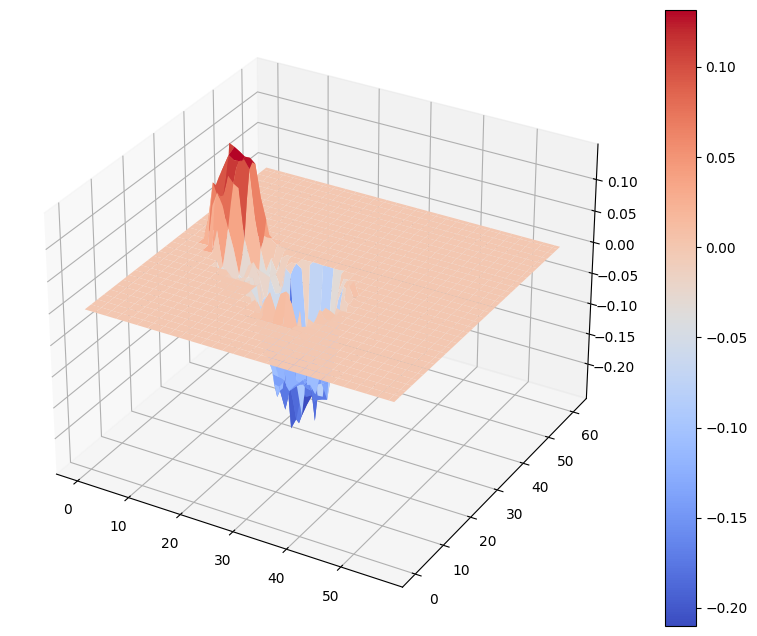

MovieWriter ffmpeg unavailable; using Pillow instead.


all time points; (50, 62, 58) (50, 62, 58)


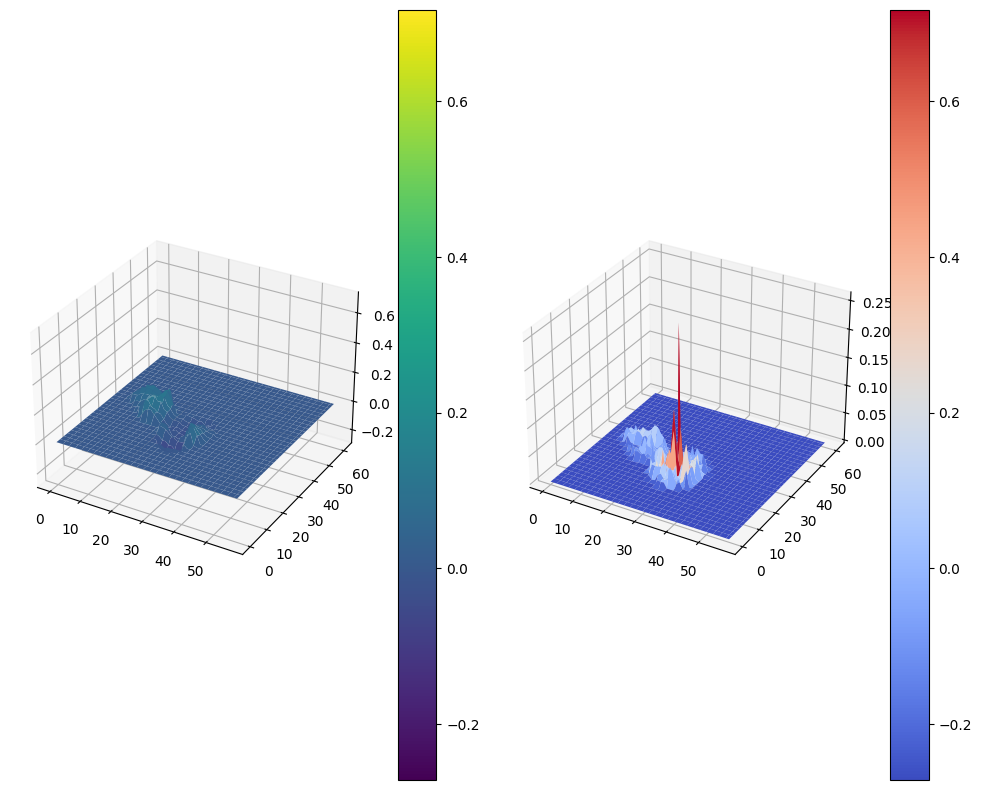

In [32]:
########
N_frames = gt['u'].shape[0]

point  = np.array([22, 25, 35])
x_line = 22
normal = np.array([-0.4, -0.5, 1]).astype(float) #[0, -0.5, 1]
normal /= np.linalg.norm(normal) #normalize normal
print('Normal vector norm:', np.linalg.norm(normal))

d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(0, gt['u'].shape[1]), range(0, gt['u'].shape[2]))

# calculate corresponding z
#TODO check if this is correct
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]


#points in plane: 3D data, 1 where plane is, 0 where no plane
points_in_plane = np.zeros_like(gt['mask'][frame])
points_in_plane[xx.flatten().astype(int), yy.flatten().astype(int), zz.flatten().astype(int)] = 1


idx_plane =  np.where(points_in_plane>0)

vx_in_plane = pred['u'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1) 
vy_in_plane = pred['v'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)
vz_in_plane = pred['w'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)
line_plane = points_in_plane[idx_plane].reshape(xx.shape[1], -1)


errorX_in_plane = error_absolut['u'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1) 
errorY_in_plane = error_absolut['v'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)
errorZ_in_plane = error_absolut['w'][:, idx_plane[0], idx_plane[1], idx_plane[2]].reshape(N_frames, xx.shape[1], -1)


###################################
def create_temporal_plane_vel_surface(line_plane, vx_in_plane, vy_in_plane, vz_in_plane,errorX_in_plane, errorY_in_plane, errorZ_in_plane, normal, vel, title):
    
    V_plane_all_T = vx_in_plane*normal[0]+ vy_in_plane*normal[1]+ vz_in_plane*normal[2]
    Error_plane_projected = np.abs(errorX_in_plane*normal[0] + errorY_in_plane*normal[1]+ errorZ_in_plane*normal[2])
    print('all time points;', V_plane_all_T.shape, Error_plane_projected.shape)
    z_min, z_max = np.min(V_plane_all_T), np.max(V_plane_all_T)
    e_min, e_max = np.min(Error_plane_projected), np.max(Error_plane_projected)
    # print(title, 'nframes:', data.shape[0])
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
    x, y = np.where(line_plane !=0)
    z = V_plane.copy()
    X, Y = np.meshgrid(range(line_plane.shape[1]), range(line_plane.shape[0]))
    surf = ax1.plot_surface(X, Y, V_plane_all_T[0], cmap=cm.viridis,vmin = z_min, vmax = z_max)
    fig.colorbar(surf)

    surf = ax2.plot_surface(X, Y, Error_plane_projected[0], cmap=cm.coolwarm,vmin = z_min, vmax = z_max)
    fig.colorbar(surf)
    
    plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    # def init():
    #     im1.set_data(np.random.random((5,5)))
    #     return [im1]

    # animation function.  This is called sequentially
    def animate(frame):
        ax1.clear()
        ax2.clear()
        V_plane_i = vx_in_plane[frame]*normal[0]+ vy_in_plane[frame]*normal[1]+ vz_in_plane[frame]*normal[2]
        surf = ax1.plot_surface(X, Y, V_plane_i, cmap=cm.viridis,vmin = z_min, vmax = z_max)
        ax1.set_zlim(z_min,z_max)

        surf = ax2.plot_surface(X, Y, Error_plane_projected[frame], cmap=cm.coolwarm)
        ax2.set_zlim(e_min,e_max)
        # fig.colorbar(surf)
        #return [im1]

    anim = animation.FuncAnimation(fig,animate, #init_func=init,
                                frames = 50,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/Animate_PlaneVel_{title}_{vel}_Slower.gif', fps=5)


#############################################0
frame = 35
#plane parameters


print(vx_in_plane.shape)
#Velocity through plane
V_plane = vx_in_plane[frame]*normal[0]+ vy_in_plane[frame]*normal[1]+ vz_in_plane[frame]*normal[2]
#######
#ax = fig.add_subplot(1, 1, 1, projection='3d')
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x, y = np.where(line_plane !=0)
z = V_plane.copy()
X, Y = np.meshgrid(range(line_plane.shape[1]), range(line_plane.shape[0]))
surf = ax.plot_surface(X, Y, V_plane, cmap=cm.coolwarm)
fig.colorbar(surf)
plt.show()

create_temporal_plane_vel_surface(line_plane, vx_in_plane, vy_in_plane, vz_in_plane,errorX_in_plane, errorY_in_plane, errorZ_in_plane,normal, 'Plane vel', 'Test')

#### Plot histogram of velocities

In [ ]:
compare_velocitywise = False
plt.figure(figsize=(8, 5))

if compare_velocitywise:

    plt.subplot(2,1, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u')
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v')
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(2,1, 2)
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w')
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.show()

else:
    plt.subplot(1, 3, 1)
    plt.hist(gt["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='black', label = 'u')
    plt.hist(pred["u"][np.where(temporal_mask !=0)].flatten(), bins = 1000, color='g', label = 'u predicted')    
    plt.xlim(np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["u"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(gt["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = 'v')
    plt.hist(pred["v"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='b', label = 'v predicted')
    plt.xlim(np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["v"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.legend()
    plt.xlabel('value')

    plt.subplot(1, 3, 3)
    plt.hist(gt["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='black', label = 'w')
    plt.hist(pred["w"][np.where(temporal_mask !=0)].flatten(), bins = 1000,  color='r', label = 'w predicted')
    plt.xlim(np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.01), np.quantile(gt["w"][np.where(temporal_mask !=0)].flatten(), 0.99))
    plt.xlabel('value')
    #plt.title("Distribution of velocity values in fluid region without outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Plot relative error and mean speed 

In [ ]:
plt.figure(figsize=(7, 4))

plt.plot(calculate_rmse(pred['u'], gt['u'], gt['mask']), label = 'u')
plt.plot(calculate_rmse(pred['v'], gt['v'], gt['mask']), label = 'v')
plt.plot(calculate_rmse(pred['w'], gt['w'], gt['mask']), label = 'w')
plt.plot(calculate_rmse(interpolate_linear['w'], gt['w'], gt['mask']), label = 'interpolate w')
plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = 'speed')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('frame')
plt.title('RMSE')

In [ ]:
plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
#plot_relative_error([gt_filepath],[res_filepath], [set_name])

#plt.legend(lst_names)
plt.title("Relative error")
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(calculate_rmse(pred['speed'], gt['speed'], gt['mask']), label = f'{set_name} speed')
plt.plot(calculate_rmse(pred['u'], gt['u'], gt['mask']), label = f'{set_name} u')
plt.plot(calculate_rmse(pred['v'], gt['v'], gt['mask']), label = f'{set_name} v')
plt.plot(calculate_rmse(pred['w'], gt['w'], gt['mask']), label = f'{set_name} w')
plt.ylabel('RMSE')
plt.xlabel('Frame')
plt.title('RMSE')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(gt['mean_speed'], label ='Ground truth',color = 'black')
plt.plot(pred['mean_speed'],'b', label= set_name, color = 'steelblue')
plt.plot(interpolate_linear['mean_speed'][:-1], label = 'linear interpolatiom', color = 'yellowgreen')
plt.plot(interpolate_cubic['mean_speed'][:-1] , label = 'cubic interpoaltion', color = 'forestgreen')
plt.xlabel("Frame")
plt.ylabel("Mean speed (cm/s)")
plt.legend()
plt.tight_layout()
plt.savefig(f'{eval_dir}/RE_RMSE_MEAN_SPEED.svg',bbox_inches='tight')
plt.show()
#lst_hgt_paths, lst_hpred_paths,lst_names, save_as = 'Relative_error_comparison.png'

In [ ]:
plt.figure(figsize=(15, 5))

rel_error_core = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], core_mask)
rel_error_bounds = calculate_relative_error_normalized(pred["u"], pred["v"], pred["w"], gt["u"], gt["v"] , gt["w"], bounds)
# plt.subplot(3, 1, 1)

#plt.legend(lst_names)
plt.title("Relative error")
plt.subplot(1,2 , 1)
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_bounds, label = f'{set_name} boundary', color = 'red')
plt.plot(rel_error_core, label = f'{set_name} core', color ='gray')
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()

plt.subplot(1, 2, 2)
frames = len(rel_error)
plt.title("Relative error")
plt.plot(rel_error, label = set_name)
plt.plot(rel_error_lin_interpolation[:-1], label = 'linear interpolation',color = 'yellowgreen')
plt.plot(rel_error_cubic_interpolation, label = 'cubic interpolation', color = 'forestgreen')
plt.plot(50*np.ones(len(rel_error)), 'k:')
plt.xlabel("Frame")
plt.ylabel("Relative error (%)")
plt.ylim((0, 100))
plt.legend()
points_in_mask = np.where(temporal_mask !=0)

reshaped_error = np.tanh(error_pointwise[:, points_in_mask[1], points_in_mask[2], points_in_mask[3]].reshape(frames, -1))
max_error = np.max(reshaped_error, axis=1)*100

sd_error = np.std(reshaped_error, axis = 1)*100
error = np.random.normal(0, sd_error, size=len(rel_error))
plt.fill_between(range(len(rel_error)), rel_error-sd_error, rel_error+sd_error, alpha = 0.5)

### Quiver plot testing

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

set_to_zero = 0.9



@widgets.interact(frame=(0, gt["u"].shape[0]-1))
def f_quiver(frame=10 ):
    #frame = 15
    u_quiver = gt['u'][frame].copy() #- pred['u'][frame]
    v_quiver = gt['v'][frame].copy() #- pred['v'][frame]
    w_quiver = gt['w'][frame].copy() #- pred['w'][frame]

    x_idx, y_idx, z_idx = random_indices3D(temporal_mask[frame], int(np.count_nonzero(temporal_mask[frame])*set_to_zero))
    x_len, y_len, z_len = gt['u'].shape[1::]

    # ev = np.array([1, 0, 0])
    #angles = np.arccos(np.dot(ev, [u, v, w]) / (np.linalg.norm(ev) * np.linalg.norm(v2)))
    # angles = np.multiply
    # Make the grid
    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    u_quiver[x_idx, y_idx, z_idx] = 0
    v_quiver[x_idx, y_idx, z_idx] = 0
    w_quiver[x_idx, y_idx, z_idx] = 0

    cropx = cropy = cropz = 25
    startx = x_len//2-(cropx//2)
    starty = y_len//2-(cropy//2)    
    startz = z_len//2-(cropz//2)
    u_quiver = u_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    v_quiver = v_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    w_quiver = w_quiver[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 

    x =x[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    y =y[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz] 
    z =z[startx:startx+cropx, starty:starty+cropy,startz:startz+cropz]

    u_new = u_quiver[np.where(u_quiver != 0)]
    v_new = v_quiver[np.where(u_quiver != 0)]
    w_new = w_quiver[np.where(u_quiver != 0)]

    x_new = x[np.where(u_quiver!=0)] 
    y_new = y[np.where(u_quiver!=0)] 
    z_new = z[np.where(u_quiver!=0)]


    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    c = plt.cm.jet(c)


    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.zlabel('z')
    plt.show()

### 3D Plot for temporal development

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

set_to_zero = 0.9



@widgets.interact(frame=(0, gt["u"].shape[0]-1))
def f_3Dplot(frame=10 ):
    #frame = 15
    u_quiver = gt['u'][frame].copy() #- pred['u'][frame]
    v_quiver = gt['v'][frame].copy() #- pred['v'][frame]
    w_quiver = gt['w'][frame].copy() #- pred['w'][frame]

    diff = np.abs(gt['speed'][frame] - pred['speed'][frame])

    x_idx, y_idx, z_idx = random_indices3D(temporal_mask[frame], int(np.count_nonzero(temporal_mask[frame])*set_to_zero))
    x_len, y_len, z_len = gt['u'].shape[1::]

    # ev = np.array([1, 0, 0])
    #angles = np.arccos(np.dot(ev, [u, v, w]) / (np.linalg.norm(ev) * np.linalg.norm(v2)))
    # angles = np.multiply
    # Make the grid
    x, y, z = np.meshgrid(np.arange(y_len),np.arange(x_len),np.arange(z_len))
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    u_quiver[x_idx, y_idx, z_idx] = 0
    v_quiver[x_idx, y_idx, z_idx] = 0
    w_quiver[x_idx, y_idx, z_idx] = 0

    u_new = u_quiver[np.where(u_quiver != 0)]
    v_new = v_quiver[np.where(u_quiver != 0)]
    w_new = w_quiver[np.where(u_quiver != 0)]

    speed_new_diff = diff[np.where(u_quiver != 0)]

    x_new = x[np.where(u_quiver!=0)] 
    y_new = y[np.where(u_quiver!=0)] 
    z_new = z[np.where(u_quiver!=0)]


    # Color by magnitude
    c = np.sqrt(u_new**2+ v_new**2+ w_new**2)#np.arctan2(w_new, u_new)
    # Flatten and normalize

    c = (c.ravel() - c.min()) / c.ptp()
    # Repeat for each body line and two head lines
    c = np.concatenate((c, np.repeat(c, 2)))
    # Colormap
    c = plt.cm.jet(c)

    


    ax.quiver(x_new, y_new, z_new, u_new, v_new, w_new, length=10, normalize=False,  pivot='middle', color = c)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    plt.xlabel('x')
    plt.ylabel('y')
    #plt.zlabel('z')
    ax = fig.add_subplot(1, 2, 2, projection='3d')

    ax.scatter(x_new, y_new, z_new, s=speed_new_diff*10,  c = speed_new_diff, cmap = plt.cm.jet)#, color=plt.cm.plasma([0.1,0.5, 0.9]))
    # s = size of marker
    plt.xlabel('x')
    plt.ylabel('y')

    plt.show()

In [ ]:
def create_temporal_comparison_gif_plt(idx, lr, hr, pred, vel):
    N = 4
    v_lr = lr[vel]
    v_hr = hr[vel]
    v_pred = pred[vel]
    v_error_abs= error_absolut[f'{vel}']
    v_NN = temporal_NN_interpolation(v_lr,v_hr.shape )

    err_max = np.quantile(v_error_abs[np.where(temporal_mask !=0)].flatten(), 0.999)

    fig = plt.figure(frameon=False)
    

    plt.subplot(1, N, 1)
    im1 = plt.imshow(v_NN[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 2)
    im2 = plt.imshow(v_hr[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')
    plt.subplot(1, N, 3)
    im3 = plt.imshow(v_pred[0, idx, :, :],vmin=min_v[vel], vmax=max_v[vel])
    plt.axis('off')

    plt.subplot(1, N, 4)
    ax = plt.gca()
    im4 = ax.imshow(v_error_abs[0, idx, :, :],vmin=0, vmax=err_max)
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(im4,fraction=0.046, pad=0.04) 
    plt.colorbar(im4, cax=cax)
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    # plt.imshow(im, vmin= 0, vmax=max_v['speed'])
    # plt.axis('off')
    


    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        im2.set_data(np.random.random((5,5)))
        im3.set_data(np.random.random((5,5)))
        im4.set_data(np.random.random((5,5)))
        return [im1, im2, im3, im4]

    # animation function.  This is called sequentially
    def animate(i):
        
        im1.set_array(v_NN[i, idx, :, :])
        im2.set_array(v_hr[i, idx, :, :])
        im3.set_array(v_pred[i, idx, :, :])
        im4.set_array(v_error_abs[i, idx, :, :])
        
        return [im1, im2, im3, im4]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = 50,
                                interval = 100) # in ms)
    print("Gif is saved under:" f'{eval_dir}/Animate_{vel}_{set_name}_M{data_model}.gif')
    anim.save(f'{eval_dir}/Animate_{vel}_{set_name}_M{data_model}_slower.gif', fps=5)

def create_temporal_comparison_gif_single(idx, data, vel, title):

    print(title, 'nframes:', data.shape[0])
    fig = plt.figure(frameon=False)
    # im1 = plt.imshow(data[0, idx, :, :],interpolation='none', vmin=min_v[vel], vmax=max_v[vel])
    plt.title(title)
    plt.axis('off')
    
    #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    plt.tight_layout()

    #initialization function: plot the background of each frame
    def init():
        im1.set_data(np.random.random((5,5)))
        return [im1]

    # animation function.  This is called sequentially
    def animate(i):
        im1.set_array(data[i, idx, :, :])
        return [im1]

    anim = animation.FuncAnimation(fig,animate, init_func=init,
                                frames = 50,
                                interval = 100) # in ms)
    anim.save(f'{eval_dir}/Animate_{title}_{vel}_Slower.gif', fps=30)

    #generate_gif_volume(combined_image[:,idx, :, : ], axis = 0, save_as = save_as)

create_temporal_comparison_gif_plt(22, lr, gt, pred, "u")
create_temporal_comparison_gif_plt(22, lr, gt, pred, "v")
create_temporal_comparison_gif_plt(22, lr, gt, pred, "w")
create_temporal_comparison_gif_plt(22, lr, gt, pred, "speed")
velo = 'u'
# create_temporal_comparison_gif_single(22, temporal_NN_interpolation(lr[velo],gt[velo].shape), velo, "LR")
# create_temporal_comparison_gif_single(22, gt[velo],velo , "HR")
# create_temporal_comparison_gif_single(22, pred[velo],velo, "4DFlowNet")
# create_temporal_comparison_gif_single(22, interpolate_linear[velo], velo, "linear interpoaltion")
# First set up the figure, the axis, and the plot element we want to animate


### Plot correlation lines

In [ ]:

@widgets.interact(frame=(0, gt["u"].shape[0]-1), x = (0, gt["u"].shape[1]-1))
def f_regression(frame=34 ):
    plt.figure(figsize=(15, 5))
    plot_correlation(gt, pred,bounds, frame_idx=frame, save_as= f'{eval_dir}/Correlation_')
    plt.show()

### Plot k, $R^2$ values in time

In [ ]:
peak_flow_frame = np.unravel_index(np.argmax(gt['speed']), shape = gt['speed'].shape)[0]
frames = len(rel_error)
k = np.zeros(3*frames)
r2 = np.zeros(3*frames)
k_bounds = np.zeros(3*frames)
r2_bounds = np.zeros(3*frames)
bounds_mask = bounds.copy()
inner_mask = temporal_mask - bounds_mask
for i, vel in enumerate(vel_colnames):
    for t in range(frames):
        k[t+i*frames], r2[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], core_mask[t])
        k_bounds[t+i*frames], r2_bounds[t+i*frames]  = calculate_k_R2( pred[vel][t], gt[vel][t], bounds[t])

min_val = np.minimum(np.min(k_bounds), np.min(r2_bounds))
max_val = np.maximum(np.max(k), np.max(r2))
for i, vel in enumerate(vel_colnames):
    plt.subplot(2, 3, i+1)
    plt.plot(range(frames), k[i*frames:i*frames+frames] , label = 'k core', color = 'black')
    plt.plot(range(frames), k_bounds[i*frames:i*frames+frames] , label = 'k boundary', color = 'red')
    plt.plot(np.ones(len(rel_error)), 'k:')
    plt.ylim([min_val, max_val])
    plt.title(vel)
    plt.xlabel('frames')
    plt.ylabel('k')
    plt.scatter(np.ones(2)*peak_flow_frame, [k[i*frames+peak_flow_frame],k_bounds[i*frames+peak_flow_frame]] )
    plt.legend()
for i, vel in enumerate(vel_colnames):
    plt.subplot(2, 3, i+4)
    plt.plot(range(frames), r2[i*frames:i*frames+frames] ,'--', label = 'r2 core', color = 'black')
    plt.plot(range(frames), r2_bounds[i*frames:i*frames+frames] ,'--', label = 'r2 boundary', color = 'red')
    plt.plot(np.ones(len(rel_error)), 'k:')
    plt.ylim([min_val, max_val])
    plt.title(vel)
    plt.xlabel('frames')
    plt.ylabel('R2')
    plt.scatter(np.ones(2)*peak_flow_frame, [r2[i*frames+peak_flow_frame], r2_bounds[i*frames+peak_flow_frame]] )
    plt.legend()
    
plt.tight_layout()

### Plot line development in time

In [ ]:

#def show_temporal_development_line(gt, lr, pred, mask, axis, indices, save_as = "Temporal_development.png"):
@widgets.interact(x=(0, gt["u"].shape[1]-1), y = (0, gt["u"].shape[2]-1), vel=vel_colnames_fluid, axis=(1, 3))
def f_temporal_development_lines(x = 30,y =40, vel = "u", axis =1):

        indices = (x, y)
        def get_line(data):
            #returns line in 4D data over all time steps
            x,y = indices
            if axis == 1:
                return data[:, :, x, y]
            elif axis == 2:
                return data[:, x, :, y]
            elif axis == 3:
                return data[:, x,  y, :]
            else:
                print("Invalid axis: Please choose axis 1, 2, 3")

        prediction = get_line(pred[vel]).transpose()
        ground_truth = get_line(gt[vel]).transpose()
        low_resolution= get_line(interpolate_NN[vel]).transpose()

        min_v = np.min([np.min(prediction), np.min(ground_truth), np.min(low_resolution)])
        max_v = np.max([np.max(prediction), np.max(ground_truth), np.max(low_resolution)])


        plt.subplot(1, 3, 1)
        plt.imshow(low_resolution, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("LR")
        plt.xlabel('t')
        plt.yticks([])

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("GT")
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1, 3, 3)
        plt.imshow(prediction, vmin = min_v, vmax = max_v, cmap='jet')
        plt.title("SR")
        plt.xticks([])
        plt.yticks([])

### Plot peak flow development

In [ ]:
#Params for plot
patch_size = 1
show_avg = True
show_pixel = True

def show_peak_flow_pixel(lr_data, hr_data,pred_data,  patch_size, show_avg, show_pixel):
    plt.figure(figsize=(7, 5))
    idx_max = np.unravel_index(np.argmax(hr_data['speed']), shape = hr_data['speed'].shape)
    x = np.arange(hr_data['speed'].shape[0])
    if show_pixel:
        plt.plot(x, hr_data['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,  label = 'ground truth pixel', color = 'black')
        plt.plot(x[1::2], lr['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'-o' ,label = 'low resolution pixel', color= 'yellowgreen')
        plt.plot(x, pred['speed'][:, idx_max[1], idx_max[2], idx_max[3]]*100,'--', label = 'prediction pixel')

    if show_avg:
        plt.plot(x,         np.average(hr_data['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,  label = 'ground truth avg', color = 'grey')
        plt.plot(x[1::2],    np.average(lr_data['speed']  [:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'-o' ,label = 'low resolution avg', color = 'olive')
        plt.plot(x,         np.average(pred_data['speed'][:, idx_max[1]-patch_size:idx_max[1]+patch_size+1, idx_max[2]-patch_size:idx_max[2]+patch_size+1, idx_max[3]-patch_size:idx_max[3]+patch_size+1], axis = (1, 2, 3))*100,'--', label = 'prediction avg', color = 'navy' )
    if show_avg:
        plt.title(f"Speed at voxel {idx_max[1::]} with average of number of voxels: {(2*patch_size+1)**3}")
    else:
        plt.title(f"Speed at voxel with index {idx_max[1::]}")
    plt.ylabel('Speed (cm/s)')
    plt.ylabel('Speed (cm/s)')
    plt.xlabel('Frame')
    plt.legend()
    plt.savefig(f'{eval_dir}/Peak_flow_frame_avg.svg',bbox_inches='tight')
    plt.show()

show_peak_flow_pixel(lr, gt, pred, patch_size, show_avg, show_pixel)